In [1]:
import math
import requests as rq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  1 of 1 completed


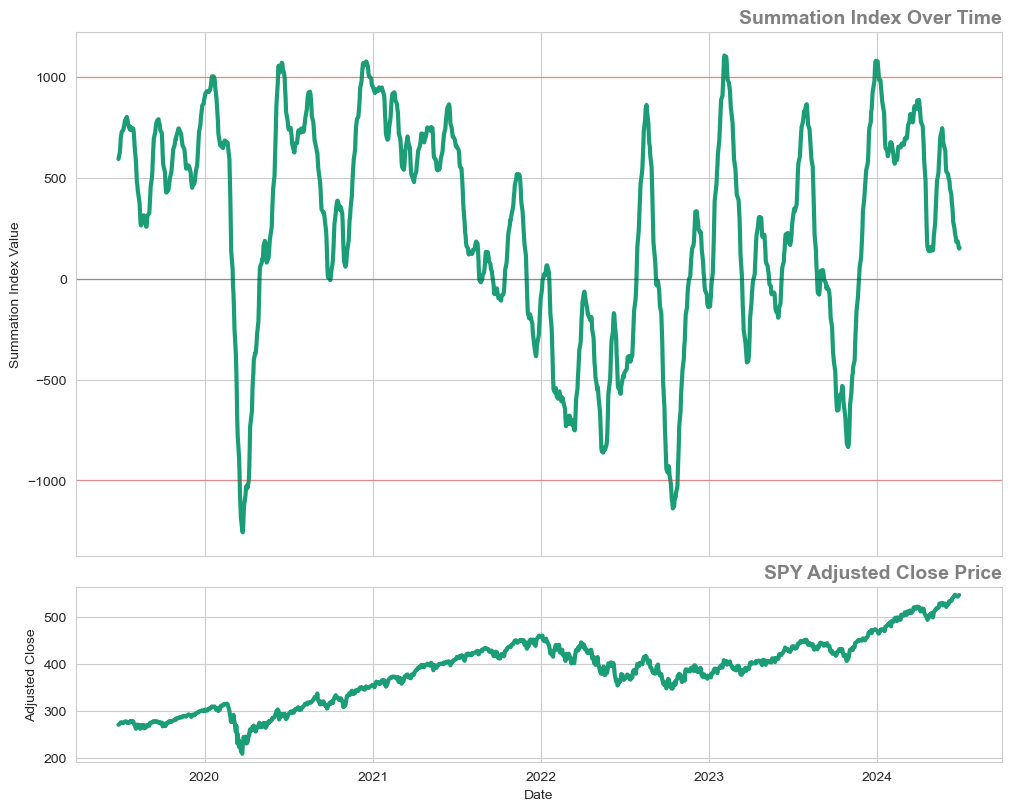

In [2]:
sns.set_style('whitegrid')

# create the function to retrieve the data
def retrieve_summation_index_data(ticker, years):
    """
    Retrieve historical Summation Index data for a given ticker and number of years.

    Args:
        ticker (str): The ticker symbol for which to retrieve the data.
        years (int): The number of years of historical data to retrieve.

    Returns:
        DataFrame: A pandas DataFrame containing the date and value of the Summation Index.
    """

    # Constants
    USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36'
    URL = f'https://stockcharts.com/c-sc/sc?s={ticker}&p=D&yr={years}&mn=0&dy=0&i=t3757734781c&img=text&inspector=yes'

    # Get raw information
    data = rq.get(URL, headers={'user-agent': USER_AGENT}).text
    data = data.split('<pricedata>')[1].replace('</pricedata>', '')

    # Process rows
    lines = data.split('|')
    processed_data = []
    for line in lines:
        cols = line.split(' ')

        # Parse the date and value, ensuring the value is not NaN before appending
        date = datetime(int(cols[1][0:4]), int(cols[1][4:6]), int(cols[1][6:8]))
        value = float(cols[3])

        if not math.isnan(value):
            processed_data.append({'date': date, 'value': value})

    # Generate and return the DataFrame
    df = pd.DataFrame.from_dict(processed_data)
    df.set_index('date', inplace=True)

    return df


# Initialize the index and retrieve the Summation Index values
ticker = '$NYSI'
years = 5
df = retrieve_summation_index_data(ticker, years)

# create a function for the graph
def plot_summation_index_with_spy(df, plot_spy=False):
    """
    Plot the Summation Index data and optionally the SPY adjusted close price on a bottom panel.

    Args:
        df (DataFrame): A pandas DataFrame containing the date and value of the Summation Index.
        plot_spy (bool): If True, plot the SPY adjusted close price on a bottom panel.
    """
    # Initialize the plot with the specified figure size
    fig, axs = plt.subplots(2 if plot_spy else 1, 1, figsize=(10, 8 if plot_spy else 4), sharex=True,
                            gridspec_kw={'height_ratios': [3, 1] if plot_spy else [1]})

    # Plot the Summation Index data on the first (top) panel
    sns.lineplot(data=df, ax=axs[0] if plot_spy else axs)
    (axs[0] if plot_spy else axs).axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    (axs[0] if plot_spy else axs).axhline(1000, color='red', linestyle='-', linewidth=1, alpha=0.3)
    (axs[0] if plot_spy else axs).axhline(-1000, color='red', linestyle='-', linewidth=1, alpha=0.3)
    (axs[0] if plot_spy else axs).set_title('Summation Index Over Time')
    (axs[0] if plot_spy else axs).set_ylabel('Summation Index Value')
    axs[0].get_legend().remove()

    if plot_spy:
        # Fetch SPY data over the same time horizon as the df
        start_date = df.index[0].strftime('%Y-%m-%d')
        end_date = df.index[-1].strftime('%Y-%m-%d')
        spy_data = yf.download('SPY', start=start_date, end=end_date)

        # Plot SPY adjusted close price on the second (bottom) panel using Seaborn
        sns.lineplot(data=spy_data['Adj Close'], ax=axs[1], label='SPY Adj Close')
        axs[1].set_title('SPY Adjusted Close Price')
        axs[1].set_ylabel('Adjusted Close')
        axs[1].get_legend().remove()

    # Set common x-axis properties and adjust layout
    plt.xlabel('Date')
    plt.tight_layout()

    # Show the plot
    plt.show()


plot_summation_index_with_spy(df, plot_spy=True)